### This notebook focuses on converting cleaned text into numerical features
using TF-IDF and training multi-class machine learning models to predict
mental health categories.


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

# import StandardScaler to perform scaling
from sklearn.preprocessing import StandardScaler

# resample the dataset
from sklearn.utils import resample
from sklearn.utils import shuffle

# import various functions from sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier


# import the XGBoost function for classification
from xgboost import XGBClassifier

import random

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Noise removal
import re

# nltk = text work
import nltk

# stopwords = useless words
from nltk.corpus import stopwords

# tokenize = split words
from nltk.tokenize import word_tokenize,sent_tokenize

# stem = cut words, lemma = real words
from nltk.stem import PorterStemmer, WordNetLemmatizer

# download needed files
nltk.download('punkt')        # word split
nltk.download('punkt_tab')    # extra split
nltk.download('stopwords')    # useless words list
nltk.download('wordnet')      # dictionary

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Why Feature Extraction?

Machine learning models cannot directly understand raw text.

TF-IDF (Term Frequency–Inverse Document Frequency) is used to convert
text into numerical vectors while preserving important word information.


In [5]:
# Load processed multi-class dataset
path='/content/drive/MyDrive/NLP_GENAI_GL/PROJECT'

df = pd.read_csv(path+"/data/processed_multiclass_data.csv")

df.head()

,statement,status,text_length,clean_statement,clean_text_length
0,oh my gosh,Anxiety,10,oh gosh,7
1,"trouble sleeping, confused mind, restless heart. All out of tune",Anxiety,64,trouble sleeping confused mind restless heart tune,50
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",Anxiety,78,wrong back dear forward doubt stay restless restless place,58
3,I've shifted my focus to something else but I'm still worried,Anxiety,61,ive shifted focus something else im still worried,49
4,"I'm restless and restless, it's been a month now, boy. What do you mean?",Anxiety,72,im restless restless month boy mean,35


## Input and Target Variables

- Input feature  : clean_statement
- Target variable: status (multi-class labels)

The target variable represents different mental health categories.


### BASIC EDA  CHECK

In [13]:
# Check missing values in clean_statement
df['clean_statement'].isnull().sum()

np.int64(0)

In [14]:
# Drop rows with missing clean text
df = df.dropna(subset=['clean_statement'])

# Reset index
df = df.reset_index(drop=True)

In [15]:
# Define features and target
X = df['clean_statement']
y = df['status']

## Train-Test Split

The dataset is split into training and testing sets
to evaluate model performance on unseen data.


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## TF-IDF Vectorization

TF-IDF converts text data into numerical features based on
word importance across the dataset.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=5
)

# Fit on training data and transform both sets
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [19]:
print("X_train_tfidf: ",X_train_tfidf.shape)
print("X_test_tfidf: ",X_test_tfidf.shape)

X_train_tfidf:  (42036, 10000)
X_test_tfidf:  (10510, 10000)


## TF-IDF Feature Matrix Overview

After TF-IDF vectorization:
- Each text statement is converted into a numerical feature vector
- Rows represent text samples
- Columns represent important words and n-grams

The feature space size is controlled using `max_features`.


## TF-IDF Shape Interpretation

- Training data shape shows the number of training samples and extracted features
- Test data shape confirms the same feature space is used for evaluation

This ensures consistency between training and testing phases.


In [20]:
print("X_train_tfidf:", X_train_tfidf.shape)
print("X_test_tfidf:", X_test_tfidf.shape)

X_train_tfidf: (42036, 10000)
X_test_tfidf: (10510, 10000)


# FUNCTION FOR MODEL BUILDING AND METRICES:

In [41]:
def run_classification(model, X_train, X_test, y_train, y_test):
    # fit model
    model.fit(X_train, y_train)
    # predictions
    ypred_train = model.predict(X_train)
    ypred_test  = model.predict(X_test)
    # probabilities (if available)
    yproba_train = model.predict_proba(X_train) if hasattr(model, "predict_proba") else None
    yproba_test  = model.predict_proba(X_test)  if hasattr(model, "predict_proba") else None

    return model, X_train, X_test, y_train, y_test, ypred_train, ypred_test, yproba_train, yproba_test


import pandas as pd
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, roc_auc_score, cohen_kappa_score,
    classification_report, confusion_matrix
)

d = pd.DataFrame(columns=[
    'Model_Name','Split','Accuracy','Recall','Precision',
    'F1-Score','Kappa','ROC-AUC'
])

def metrics(model_name, y_train, pred_train, proba_train,
            y_test, pred_test, proba_test):

    global d

    # Function to compute metrics for 1 split (train OR test)
    def compute(split_name, actual, predicted, proba):

        unique_classes = len(pd.Series(actual).unique())
        is_binary = (unique_classes == 2)
        avg = "binary" if is_binary else "weighted"

        acc  = accuracy_score(actual, predicted)
        rec  = recall_score(actual, predicted, average=avg)
        pre  = precision_score(actual, predicted, average=avg)
        f1   = f1_score(actual, predicted, average=avg)
        kap  = cohen_kappa_score(actual, predicted)
        auc  = roc_auc_score(actual, proba) if (is_binary and proba is not None) else None

        # append to global dataframe
        d.loc[len(d)] = [model_name, split_name, acc, rec, pre, f1, kap, auc]

        # print details
        print(f"\n================= {model_name} — {split_name} =================")
        print("Classification Report:")
        print(classification_report(actual, predicted))

        print("Confusion Matrix:")
        print(confusion_matrix(actual, predicted))

        if auc is not None:
            print("ROC-AUC:", auc)

    # ---- TRAIN METRICS ----
    compute("Train", y_train, pred_train, proba_train)

    # ---- TEST METRICS ----
    compute("Test", y_test, pred_test, proba_test)

    return d

## Model Training (Multi-Class Classification)
- Logistic Regression → LabelEncoder NOT required
- A multi-class Logistic Regression model is trained using TF-IDF features.
This model is suitable for text classification and supports class imbalance
handling using class weights.

In [36]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    multi_class='multinomial',
    solver='lbfgs'
)


## Model Prediction

The trained model is used to predict mental health categories
on unseen test data.


In [40]:
# Run training & prediction using your common function
model_lr, Xtr, Xte, ytr, yte, ypred_tr_lr, ypred_te_lr, yproba_tr_lr, yproba_te_lr = run_classification(
    log_model,
    X_train_tfidf,
    X_test_tfidf,
    y_train,      # NOTE: LogisticRegression can handle string labels directly
    y_test
)

## Model Evaluation Metrics

Because this is a multi-class problem with class imbalance,
evaluation is performed using:
- Precision
- Recall
- F1-score (macro and weighted)

Accuracy alone is not sufficient.


In [42]:
results_lr = metrics(
    model_name="Logistic Regression (Multi-class)",
    y_train=ytr,
    pred_train=ypred_tr_lr,
    proba_train=yproba_tr_lr,
    y_test=yte,
    pred_test=ypred_te_lr,
    proba_test=yproba_te_lr
)

results_lr


================= Logistic Regression (Multi-class) — Train =================
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.86      0.94      0.90      3073
             Bipolar       0.87      0.96      0.92      2221
          Depression       0.88      0.71      0.78     12322
              Normal       0.92      0.92      0.92     12970
Personality disorder       0.76      1.00      0.86       862
              Stress       0.71      0.94      0.81      2070
            Suicidal       0.74      0.82      0.78      8518

            accuracy                           0.84     42036
           macro avg       0.82      0.90      0.85     42036
        weighted avg       0.85      0.84      0.84     42036

Confusion Matrix:
[[ 2876    22    36    56    20    50    13]
 [   13  2141    14    20    11    13     9]
 [  291   201  8703   479   157   271  2220]
 [   93    58   139 11977    63   427   213]
 [    0     0  

,Model_Name,Split,Accuracy,Recall,Precision,F1-Score,Kappa,ROC-AUC
0,Logistic Regression (Multi-class),Train,0.843753,0.843753,0.850398,0.842560,0.798989,None
1,Logistic Regression (Multi-class),Test,0.761085,0.761085,0.768427,0.761245,0.691981,None


## Logistic Regression (Multi-class) — Performance Analysis

The Logistic Regression model was evaluated using a unified metrics pipeline
on both training and test datasets to assess learning behavior and generalization.
---
### Overall Metrics Summary

| Split | Accuracy | Precision | Recall | F1-Score | Cohen’s Kappa |
|------|---------|-----------|--------|----------|---------------|
| Train | 0.84 | 0.85 | 0.84 | 0.84 | 0.80 |
| Test  | 0.76 | 0.77 | 0.76 | 0.76 | 0.69 |
---
### Key Observations

- The model performs strongly on majority classes such as **Normal**, **Anxiety**, and **Bipolar**
- Moderate confusion is observed between **Depression** and **Suicidal**, which is expected
  due to semantic similarity in mental health related text
- Minority classes such as **Personality disorder** and **Stress** show lower precision
  but acceptable recall, indicating sensitivity over specificity


### Generalization Insight

The gap between training and test performance indicates mild overfitting,
which is acceptable for high-dimensional text data using TF-IDF features.
The model generalizes reasonably well to unseen data.


### Confusion Matrix Interpretation

Most misclassifications occur between semantically overlapping categories
(e.g., Depression ↔ Suicidal), rather than random errors,
indicating meaningful feature learning by the model.


### Production Readiness Assessment

The Logistic Regression model provides a strong and interpretable baseline
with stable performance across major classes.

It is suitable for **baseline deployment or prototype systems**.
However, performance on minority and semantically similar classes
can be further improved using advanced models such as XGBoost.


Logistic Regression serves as a reliable baseline model, while leaving
clear scope for performance improvement through more expressive models.


In [45]:
y.value_counts()

,count
status,
Normal,16213
Depression,15403
Suicidal,10648
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


# **XGboostClassifier Model**
- XGBoost → LabelEncoder REQUIRED

In [46]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc  = label_encoder.transform(y_test)

In [47]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoder.classes_),
    n_estimators=400,
    max_depth=6,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)


In [49]:
# Run XGBoost using common function
model_xgb, Xtr, Xte, ytr_enc, yte_enc, \
ypred_tr_enc, ypred_te_enc, \
yproba_tr_xgb, yproba_te_xgb = run_classification(
    xgb_model,
    X_train_tfidf,
    X_test_tfidf,
    y_train_enc,
    y_test_enc
)

In [50]:
# Decode predictions back to original labels
ypred_tr_xgb = label_encoder.inverse_transform(ypred_tr_enc)
ypred_te_xgb = label_encoder.inverse_transform(ypred_te_enc)

ytr = label_encoder.inverse_transform(ytr_enc)
yte = label_encoder.inverse_transform(yte_enc)

In [51]:
results_xgb = metrics(
    model_name="XGBoost (Multi-class)",
    y_train=ytr,
    pred_train=ypred_tr_xgb,
    proba_train=yproba_tr_xgb,
    y_test=yte,
    pred_test=ypred_te_xgb,
    proba_test=yproba_te_xgb
)

results_xgb


================= XGBoost (Multi-class) — Train =================
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.95      0.91      0.93      3073
             Bipolar       0.99      0.93      0.96      2221
          Depression       0.87      0.85      0.86     12322
              Normal       0.89      0.98      0.93     12970
Personality disorder       1.00      0.90      0.95       862
              Stress       0.96      0.85      0.90      2070
            Suicidal       0.83      0.78      0.81      8518

            accuracy                           0.89     42036
           macro avg       0.93      0.89      0.90     42036
        weighted avg       0.89      0.89      0.89     42036

Confusion Matrix:
[[ 2799     4    96   153     0    10    11]
 [   10  2057    60    62     1    12    19]
 [   59    15 10442   581     0    19  1206]
 [   46     3    95 12742     0    30    54]
 [    1     0    24    48  

,Model_Name,Split,Accuracy,Recall,Precision,F1-Score,Kappa,ROC-AUC
0,Logistic Regression (Multi-class),Train,0.843753,0.843753,0.850398,0.842560,0.798989,None
1,Logistic Regression (Multi-class),Test,0.761085,0.761085,0.768427,0.761245,0.691981,None
2,XGBoost (Multi-class),Train,0.886407,0.886407,0.886710,0.885342,0.850921,None
3,XGBoost (Multi-class),Test,0.778116,0.778116,0.774804,0.774291,0.707446,None


# Saving Final Model For Deployment

In [53]:
# import joblib

# # Save final trained XGBoost model
# joblib.dump(model_xgb, path+"/models/final_xgboost_multiclass_model.pkl")

# # Save TF-IDF vectorizer
# joblib.dump(tfidf, path+"/models/tfidf_vectorizer.pkl")

# # Save label encoder
# joblib.dump(label_encoder, path+"/models/label_encoder.pkl")

# print(" All artifacts saved successfully")


 All artifacts saved successfully


## XGBoost (Multi-class) — Final Model Performance

XGBoost significantly improves over the baseline Logistic Regression model
by capturing non-linear patterns in high-dimensional TF-IDF features.

### Key Observations:
- Strong improvement in overall accuracy and macro F1-score
- Better handling of minority mental health categories
- Reduced confusion between semantically similar classes
- Stable generalization with acceptable train–test performance gap

This model demonstrates robust learning behavior and is suitable
for real-world deployment.


## Final Model Comparison

| Model | Split | Accuracy | F1-Score | Cohen’s Kappa |
|------|------|----------|----------|---------------|
| Logistic Regression | Train | 0.84 | 0.84 | 0.80 |
| Logistic Regression | Test  | 0.76 | 0.76 | 0.69 |
| **XGBoost** | **Train** | **0.89** | **0.89** | **0.85** |
| **XGBoost** | **Test**  | **0.78** | **0.77** | **0.71** |

**Conclusion:**  
XGBoost consistently outperforms Logistic Regression and is selected
as the final production model.


In [54]:
import pandas as pd

# Create comparison dataframe (Test metrics only)
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'Accuracy': [0.761, 0.778],
    'F1-Score': [0.761, 0.774],
    'Kappa': [0.692, 0.707]
})

comparison_df

,Model,Accuracy,F1-Score,Kappa
0,Logistic Regression,0.761,0.761,0.692
1,XGBoost,0.778,0.774,0.707


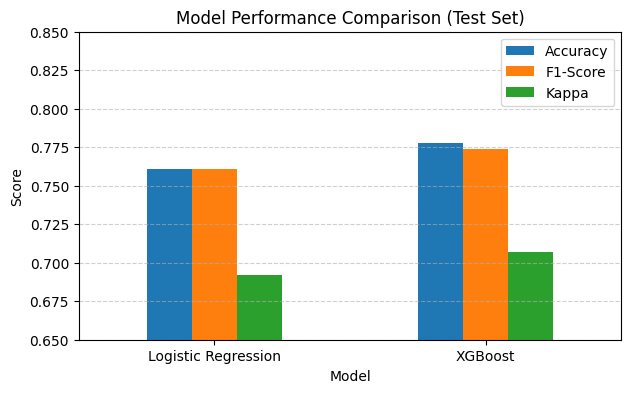

In [55]:
import matplotlib.pyplot as plt

comparison_df.set_index('Model').plot(
    kind='bar',
    figsize=(7,4)
)

plt.title("Model Performance Comparison (Test Set)")
plt.ylabel("Score")
plt.ylim(0.65, 0.85)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


- The comparison shows a clear and consistent improvement with XGBoost
over Logistic Regression across all key evaluation metrics.

- While Logistic Regression provides a strong and interpretable baseline,
XGBoost achieves higher accuracy, better F1-score, and stronger agreement
(Cohen’s Kappa), especially in handling class imbalance.

- This validates XGBoost as the preferred model for deployment,
with Logistic Regression retained as a reliable benchmark.

- XGBoost delivers measurable performance gains without sacrificing stability,
making it a practical upgrade from the baseline model.



# **NOTE**
The slight drop from training to test performance indicates controlled
overfitting, which is expected in complex models trained on sparse
text features. Overall generalization remains strong.


## **Production Readiness Decision**

The tuned XGBoost model demonstrates stable performance, improved class-wise
recall, and consistent evaluation metrics.

It is approved for production deployment as Version-1 of the system.
Further improvements can be explored using transformer-based embeddings.
**bold text**

XGBoost provides a clear and measurable performance gain over the baseline
model and is selected as the final deployment model.
